In [1]:
%load_ext autoreload
%autoreload 2
from utils import *

<div style="font-size: 36px;">The Effects of Working Memory on Program Tracing</div>

In this series of experiments, my goal is to understand how working memory affects our ability to mentally trace through a simple program. We are going to analyze the language of *arithmetic programs*, i.e. those containing numbers, binary operators, variables with assignment, and functions. Here's an example program demonstrating the full range of language features.

In [2]:
def f(x):
    y = x + 1
    return y + x

def g(z, q):
    return f(z - q)

g(1, 4)

-5

We will focus on the task of mentally computing the output of the function without use of external aids (pen/paper, calculator, etc.) except for the program listing. My ultimate goal is to produce a model that could predict the response time and accuracy of the average programmer tracing an arbitrary program. 

To focus on working memory, all arithmetic will be addition and subtraction, with all constants in the range 0-9. The main effects I'm interested in are how program state (variables + call stack) interact with working memory.

# A model of working memory

First, we need to create a model of working memory that fits experimental data on basic tracing tasks. For now, we will ignore functions and just consider variable assignment. Consider a program like this:

In [3]:
x = 1
y = x + 1
z = x - y
w = z + x
y - w

2

I hypothesize that a programmer will trace this code from top to bottom, and store variable/value pairs (e.g. x=1, y=2) in working memory. This raises a few key questions:
* How are variable/value pairs represented as chunks? e.g. is a pair one chunk, or is each part a separate chunk somehow associated to each other?
* How many variable/value pair chunks can a programmer store in memory? 

We'll start with the simplest "slots" model as used in visual working memory research. Assume working memory has $K$ slots. Each variable/value pair is a single slot (or chunk). When remembering a new chunk while at capacity, we randomly evict an existing chunk with uniform probability. This model is represented by the `WorkingMemory` class:

In [4]:
from random import choice

class BasicWM:
    def __init__(self, K):
        self.chunks = []
        self.max_chunks = K
        
    def store(self, variable, value):
        # Delete a random chunk once memory is at capacity
        if len(self.chunks) == self.max_chunks:
            self.chunks.remove(choice(self.chunks))
            
        self.chunks.append((variable, value))
        
    def load(self, variable):
        for (other_variable, value) in self.chunks:
            if variable == other_variable:
                return value
        return None
    
# Example of using BasicWM
wm = BasicWM(K=2)
wm.store("a", 1)
wm.store("b", 2)
assert wm.load("a") == 1
wm.store("c", 3)
assert len(wm.chunks) == 2

To evaluate whether this model usefully captures the phenomena of a human tracing a program, we start with a simple experiment.

## Experiment 1: Variable span

In this experiment, we measure the number of variable/value pairs a participant can recall after a short delay. This task follows the same structure as many other kinds of span experiments (digit span, letter span, etc.) for measuring the capacity of working memory.


**Method:** for $N_{var} = 3 \ldots 6$, the participant is shown $N_{var}$ variable bindings. For example, at $N_{var} = 3$, the listing could be:

```python
x = 3
r = 8
w = 2
```

Each variable name is randomly selected (without replacement) from the letters a-z, and the constants are randomly selected from the digits 1-9. The order of the names is randomized as well. The participant is given $1.5 * N_{var}$ seconds to remember the variables. A blank screen is shown for 1 second, and then the participant is prompted with $N_{var}$ rows of two input boxes to recall the variable and value. 

The participant did 10 trials of the task for each value of $N_{var}$.

**Results:** for each trial, we computed the number of pairs where both the variable and value were correctly recalled. This distribution is shown below:

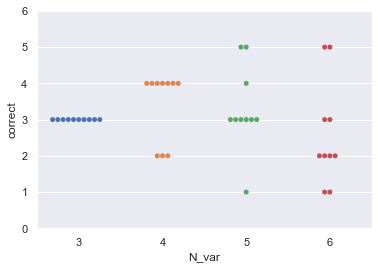

In [5]:
experiment = VariableSpanExperiment()
def plot_actual(ax):
    sns.swarmplot(data=experiment.results(), x='N_var', y='correct', ax=ax)
    ax.set_yticks(list(range(0, 7)))
plot_actual(plt.gca())

These results suggest that the participant can remember 3 variables perfect, 4 variables mostly well, then with degrading performance for 5 and 6 variables. Two key observations: 
1. 5 and 6 variables have high variance. Performance ranges from perfect to a single variable remembered.
2. Performance actively degrades, rather than caps out.

Next, we will simulate performing the same task using the `BasicWM` model of working memory. In our simulation, we iterate through the observed variables, storing each to memory. Then, we try to fetch each variable. The code for the simulation is shown below.

In [6]:
import inspect
print(inspect.getsource(experiment.simulate_trial))

    def simulate_trial(self, variables, WorkingMemory):
        wm = WorkingMemory()
        for v in variables:
            wm.store(v['variable'], v['value'])

        response = []
        for v in variables:
            value = wm.load(v['variable'])
            if value is not None:
                response.append({'variable': v['variable'], 'value': value})

        return response



Let's assume for now that the size of working memory is $K = $. We run the WM simulation for 1,000 trials per $N_{var}$ and report the distribution of correct answers, as above. On the left is the experimental data, and on the right is the simulated data.

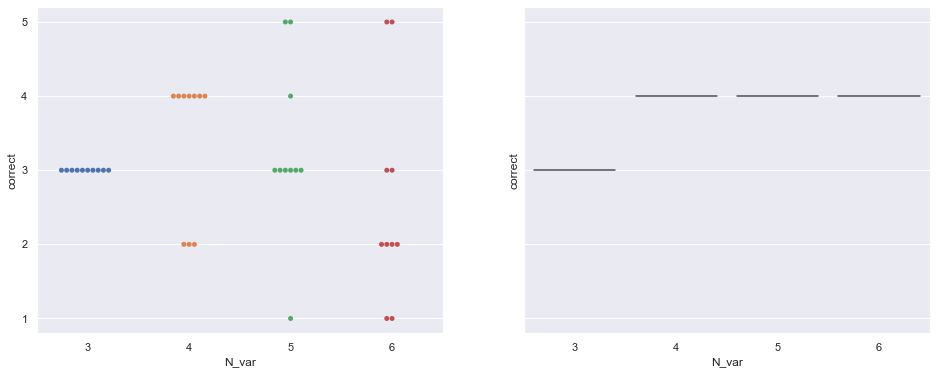

In [59]:
def plot_sim(sim_data):
    _, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    plot_actual(axes[0])
    sns.violinplot(
        data=sim_data,
        x='N_var',
        y='correct',
        cut=0, 
        ax=axes[1])
    
sim_data = experiment.simulate(lambda: BasicWM(K=4))
plot_sim(sim_data)

Our simulation performs as expected -- it memorizes perfectly up to K things, and gets the rest wrong. We can see that this doesn't match the actual noise of the experimental data, nor does it capture the decrease in performance as the number of chunks increases.

To capture these phenomena, let's explore an alternative model of working memory. Assume that WM still has distinct chunks, and variable/value pairs form a single chunk. Rather than capping the number of chunks, let's instead describe the probability of forgetting a chunk as a function of the state of memory. That is, a conditional distribution:

$$
\begin{align*}
p_\text{forget} &\sim P(\text{forgetting} \mid \text{number of chunks} = N_\text{chunks})\\
\text{did forget} &\sim \text{Bernoulli}(p_\text{forget})
\end{align*}
$$

Intuitively, the probability should be small for fewer chunks, and higher for more chunks. A simple way to capture this intuition is to represent the probability of forgetting as a linear function over the parameters to the Beta distribution.

$$
p_\text{forget} \sim \text{Beta}(\alpha N_\text{chunks} + \beta, 1)
$$

If $\alpha$ is positive, then as $N_\text{chunks}$ increases, the probability of forgetting increases. The offset $\beta$ allows us to capture the point at which forgetting begins to occur, e.g. if $\alpha = 1$ and $\beta = -3$ then $p_\text{forget} \approx 0$ until $N_\text{chunks} > 3$.

We programmatically encode this model as a new class `BetaWM`:

In [8]:
from torch import distributions as dist

class BetaWM(BasicWM):
    def __init__(self, alpha, beta):
        self.chunks = []
        self.alpha = alpha
        self.beta = beta
        
    def store(self, variable, value):
        N_chunks = len(self.chunks)
        p_forget = dist.Beta(N_chunks * self.alpha + self.beta, 1).sample()
        if N_chunks > 0 and dist.Bernoulli(p_forget).sample().item() == 1.:
            self.chunks.remove(choice(self.chunks))
            
        self.chunks.append((variable, value))

Using a mean-squared-error loss, we run a grid search over a reasonable parameter space to find a value of $\alpha$ and $\beta$ that fit the experimental data.


Best params:  loss     2.174894
alpha    2.250000
beta    -7.000000
Name: 86, dtype: float64
Parameter space: 


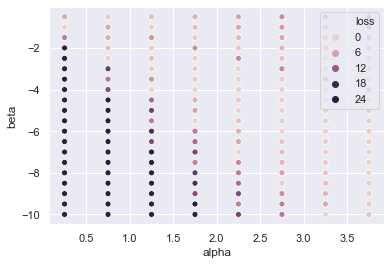

In [63]:
import numpy as np
best_params_beta, all_params_beta = experiment.grid_search(BetaWM, {
    'alpha': np.arange(0.25, 4, 0.5),
    'beta': np.arange(-10, 0, 0.5)
})
print('Best params: ', best_params_beta)
print('Parameter space: ', )
sns.scatterplot(data=all_params_beta, x='alpha', y='beta', hue='loss')

We can now simulate the beta model using these optimal parameters. The graphs below compare the experimental data (left) against the simulated data (right).

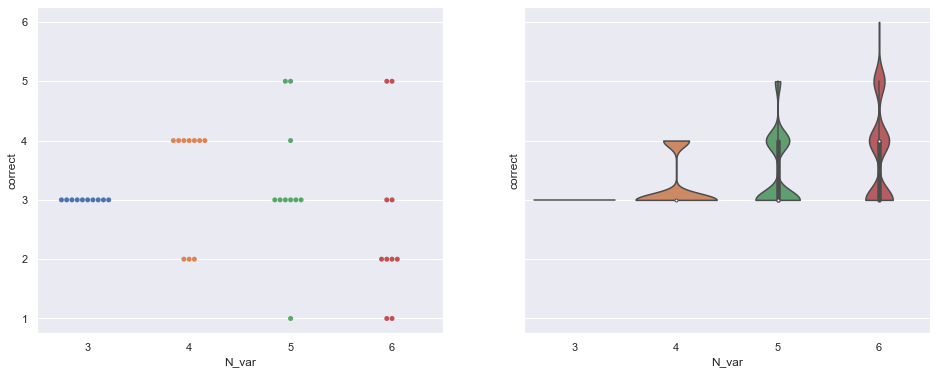

In [64]:
sim_data = experiment.simulate(WorkingMemory=lambda: BetaWM(
    alpha=best_params_beta.alpha, beta=best_params_beta.beta))
plot_sim(sim_data)

The new model now more effectively models the variance of the experimental data. However, there are still two problems in the simulation:
1. The results for 6 variables are not worse than for 5 variables, indicating that this model does not account for the degradation at high $N_{var}$.
2. The simulation averages out bimodal performance in the experiment. For example, at $N_{var} = 4$, the simulation has an average of 3 correct, while the experimental data has all trials at either 4 or 2 correct. 

The first issue could potentially be addressed by using a different function for the input to Beta, e.g. a quadratic to capture that more chunks significantly increases forgetfulness.

For the second issue, I hypothesize that the actual cognitive phenomenon showing in the data is accidentally swapping variable/value associations, as opposed to forgetting. Prior work on visual working memory have also shown that task failures when remembering associated data (e.g. location + color of a square) can be better explained through swapping than through random guessing (see [Bays et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3118422/)).

We can represent swapping error in the model similarly to forgetting. Every time a variable is stored, it has some probability of being swapped with another variable, also modeled as a beta distribution paramterized by a linear function of the chunk size. The code:

In [25]:
class SwapWM(BetaWM):
    def __init__(self, alpha, beta, alpha_swap, beta_swap):
        super().__init__(alpha, beta)
        self.alpha_swap = alpha_swap
        self.beta_swap = beta_swap
        
    def store(self, variable, value):
        super().store(variable, value)
        
        N_chunks = len(self.chunks)
        p_swap = dist.Beta(N_chunks * self.alpha_swap + self.beta_swap, 1).sample()      
        if N_chunks > 1 and dist.Bernoulli(p_swap).sample().item() == 1.:
            i = choice(range(N_chunks - 1))
            j = N_chunks - 1
            tmp = self.chunks[i][1]
            self.chunks[i] = (self.chunks[i][0], self.chunks[j][1])
            self.chunks[j] = (self.chunks[j][0], tmp)     

We now do a 4-dimensional grid search over the parameter space. Now that our paramater space is too large to visualize on one plot, we use a pairplot to show the relationship between pairs of parameters.


Best params:  loss          0.087959
alpha         1.250000
beta         -5.000000
alpha_swap    1.250000
beta_swap    -4.500000
Name: 1621, dtype: float64
Parameter space: 


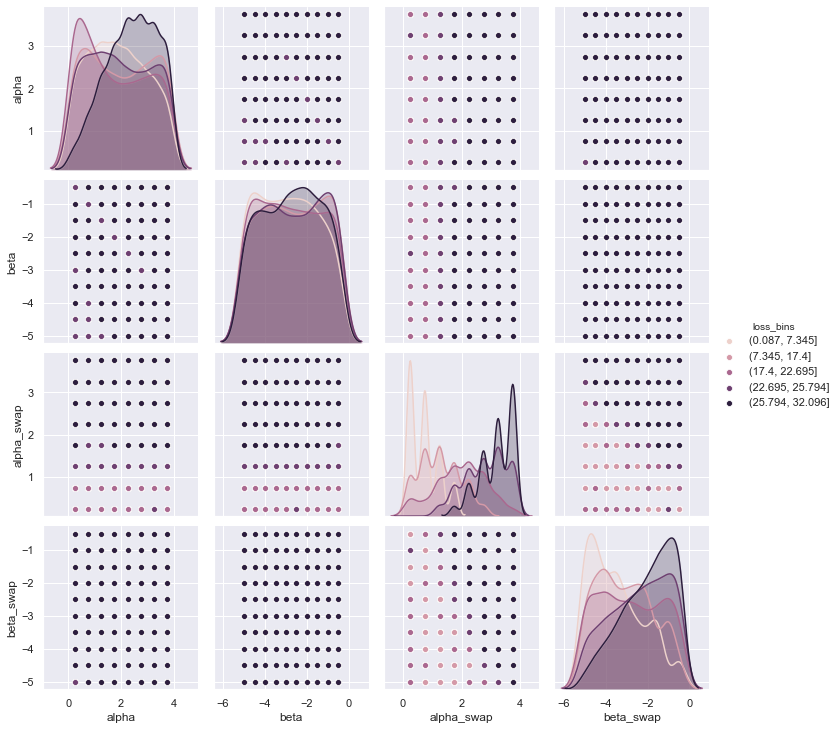

In [57]:
best_params_swap, all_params_swap = experiment.grid_search(SwapWM, {
    'alpha': np.arange(0.25, 4, 0.5),
    'beta': np.arange(-5, 0, 0.5),
    'alpha_swap': np.arange(0.25, 4, 0.5),
    'beta_swap': np.arange(-5, 0, 0.5)
}, N_trials=100)
print('Best params: ', best_params_swap)
print('Parameter space: ')
all_params_swap['loss_bins'] = pd.qcut(all_params_swap.loss, q=5)
sns.pairplot(data=all_params_swap, hue='loss_bins', palette=sns.cubehelix_palette(5), 
             vars=('alpha', 'beta', 'alpha_swap', 'beta_swap'))

Like before, we simulate the model 1000 times and plot the distribution of simulated responses against the experimental data.

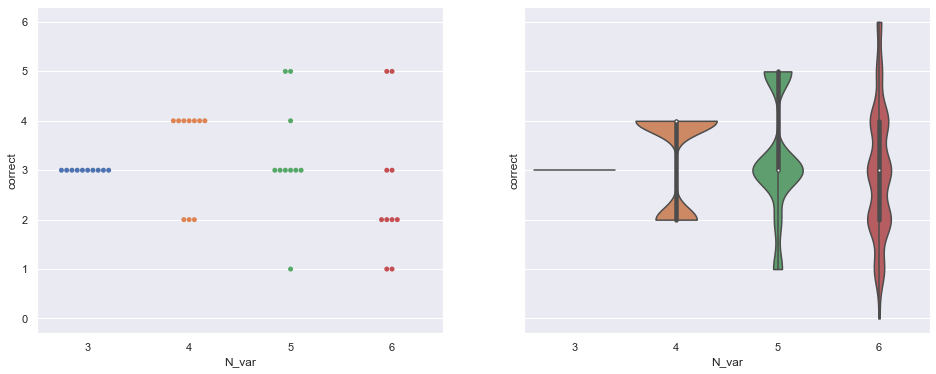

In [61]:
sim_data = experiment.simulate(WorkingMemory=lambda: SwapWM(
    alpha=best_params_swap.alpha, beta=best_params_swap.beta, 
    alpha_swap=best_params_swap.alpha_swap, beta_swap=best_params_swap.beta_swap))

plot_sim(sim_data)

Excellent! The model now looks more like the experimental data. And it successfully captures the two phenomenon: split performance between 4/2 correct, and decreasing performance for $N = 5, 6$.